In [110]:
import pandas as pd
import numpy as np
import sys
sys.path.append('C:\\Users\\saleh\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages')

import os
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import plot_importance
from math import ceil

import seaborn as sns
import matplotlib.dates as mdates

In [2]:
# Define the folder path
folder_path = 'C:\\Users\\saleh\\Documents\\kaggle_sales_forecast\\data'

# Initialize a list to store dataframes
dataframes = []

# Optionally, if you want to store dataframes in a dictionary with filenames as keys
dataframes_dict = {os.path.splitext(filename)[0]: pd.read_csv(os.path.join(folder_path, filename)) for filename in os.listdir(folder_path) if filename.endswith(('.csv', '.xls'))}


In [3]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
train = dataframes_dict['train']
transactions = dataframes_dict['transactions']
stores = dataframes_dict['stores']
holidays_events = dataframes_dict['holidays_events']
oil = dataframes_dict['oil']

In [4]:
train['date'] = pd.to_datetime(train['date'])

In [5]:
def create_date_features(df):
    
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['dow'] = df['date'].dt.dayofweek
    

    def week_of_month(dt):
        """ Returns the week of the month for the specified date.
        """

        first_day = dt.replace(day=1)

        dom = dt.day
        adjusted_dom = dom + first_day.weekday()

        return int(ceil(adjusted_dom/7.0))
    
    df['weekofmonth'] = df['date'].apply(week_of_month)
    
    return df

In [6]:
train = pd.merge(left=train, right=stores, how='left', on='store_nbr')
#train

In [7]:
test = dataframes_dict['test']
test['date'] = pd.to_datetime(test['date'])
test = pd.merge(left=test, right=stores, how='left', on='store_nbr')
#test

In [8]:
holidays_events['date'] = pd.to_datetime(holidays_events['date'])
holidays_events = holidays_events.rename(columns={
    'type': 'holiday_type',
    'description': 'holiday_description'
})
national_holidays = holidays_events[holidays_events.locale == 'National']
regional_holidays = holidays_events[holidays_events.locale == 'Regional']
local_holidays = holidays_events[holidays_events.locale == 'Local']
#local_holidays

In [9]:
train = pd.merge(left=train, right=national_holidays, how='left', on='date')
test = pd.merge(left=test, right=national_holidays, how='left', on='date')

In [10]:
# Merge df1 and df2 based on 'col1' and 'col2'
merged_train = pd.merge(train, regional_holidays, left_on=['date', 'state'], right_on=['date', 'locale_name'], how='left', suffixes=('', '_update'))

# Update df1 with the values from df2 wherever df2 is joined
for col in regional_holidays.columns:
    if col not in ['date', 'locale_name']:  # Exclude the join columns
        merged_train[col] = merged_train[col + '_update'].combine_first(merged_train[col])

# Drop the extra columns used for updating
merged_train = merged_train[train.columns]

merged_test = pd.merge(test, regional_holidays, left_on=['date', 'state'], right_on=['date', 'locale_name'], how='left', suffixes=('', '_update'))

# Update df1 with the values from df2 wherever df2 is joined
for col in regional_holidays.columns:
    if col not in ['date', 'locale_name']:  # Exclude the join columns
        merged_test[col] = merged_test[col + '_update'].combine_first(merged_test[col])

# Drop the extra columns used for updating
merged_test = merged_test[test.columns]
#merged_test

In [11]:
merged_train = merged_train.drop('locale_name', axis=1)
merged_test = merged_test.drop('locale_name', axis=1)

In [12]:
merged_test.columns[merged_test.isna().any()]

Index(['holiday_type', 'locale', 'holiday_description', 'transferred'], dtype='object')

In [13]:
merged_train.fillna('NA', inplace=True)
merged_test.fillna('NA', inplace=True)

In [14]:

merged_train['cluster'] = merged_train['cluster'].astype(object)
merged_test['cluster'] = merged_test['cluster'].astype(object)


In [15]:
def create_lag_features(df, group_cols, target_col, lags=[1, 7, 30]):
    """
    Create lag features and rolling statistics for the target column within each group.

    Parameters:
    - df: pandas DataFrame containing the data
    - group_cols: list of column names representing the groups (e.g., ['store', 'family'])
    - target_col: column name representing the target variable (e.g., 'sales')
    - lags: list of integers representing lag periods (e.g., [1, 7, 30])

    Returns:
    - df: pandas DataFrame with the newly created lag and rolling features
    """
    # Ensure the data is sorted by the group columns and date
    df = df.sort_values(by=group_cols + ['date'])
    
    # Create lag features
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df.groupby(group_cols)[target_col].shift(lag)

    return df


In [16]:
# Add the 'sales' column to the test set with placeholder values (e.g., 0)
merged_test['sales'] = 0
merged_test['set'] = 'test'
merged_train['set'] = 'train'

# Concatenate the train and test sets
combined_df = pd.concat([merged_train, merged_test],ignore_index=True)

# Step 2: Create Lag Features on the Combined Dataset
combined_df = create_lag_features(combined_df, group_cols=['family','store_nbr'], target_col='sales', lags = [30,60,180,365])

merged_train_with_lags = combined_df[combined_df.set=='train']
merged_test_with_lags = combined_df[combined_df.set=='test']

In [17]:
merged_test_with_lags = merged_test_with_lags.drop(columns=['sales','set'])
merged_train_with_lags = merged_train_with_lags.drop(columns=['set'])

In [18]:
#merged_train_with_lags.tail()
daily_sales = merged_train_with_lags.groupby(['store_nbr', 'date'])['sales'].sum().reset_index()
#daily_sales.tail()

In [19]:
# Checking how many zero sales days does each store have
zero_sales_days = daily_sales[daily_sales['sales'] == 0]

zero_sales_count = zero_sales_days.groupby('store_nbr').size().reset_index(name='zero_sales_days')
#zero_sales_count

In [20]:
# Removing data for stores for days where total sales are zero for the day.

non_zero_sales_days = daily_sales[daily_sales['sales'] > 0]

train_filtered = pd.merge(merged_train_with_lags, non_zero_sales_days[['store_nbr', 'date']], on=['store_nbr', 'date'])




In [21]:
# Cluster analysis
store_count_per_cluster = train_filtered.groupby('cluster')['store_nbr'].nunique().reset_index(name='store_count')

average_sales_per_cluster = train_filtered[train_filtered.date.dt.year > 2015].groupby('cluster')['sales'].mean().reset_index(name='average_sales')

cluster_summary = pd.merge(store_count_per_cluster, average_sales_per_cluster, on='cluster')

#cluster_summary



In [22]:
store_count_per_type = train_filtered.groupby('type')['store_nbr'].nunique().reset_index(name='store_count')

average_sales_per_type = train_filtered[train_filtered.date.dt.year > 2015].groupby('type')['sales'].mean().reset_index(name='average_sales')

type_summary = pd.merge(store_count_per_type, average_sales_per_type, on='type')

type_summary

,type,store_count,average_sales
0,A,9,977.32
1,B,8,447.08
2,C,15,246.06
3,D,18,453.15
4,E,4,383.75


In [23]:
train_filtered[train_filtered.date.dt.year > 2015].groupby('type')['sales'].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
A,160446.00,977.32,2345.52,0.00,12.00,67.00,675.00,76090.00
B,152922.00,447.08,1200.61,0.00,3.00,21.00,320.00,89576.36
C,293469.00,246.06,679.37,0.00,1.00,12.00,160.00,31125.52
D,350130.00,453.15,1164.72,0.00,5.00,31.00,283.00,124717.00
E,78144.00,383.75,943.65,0.00,2.00,16.00,250.00,16542.90


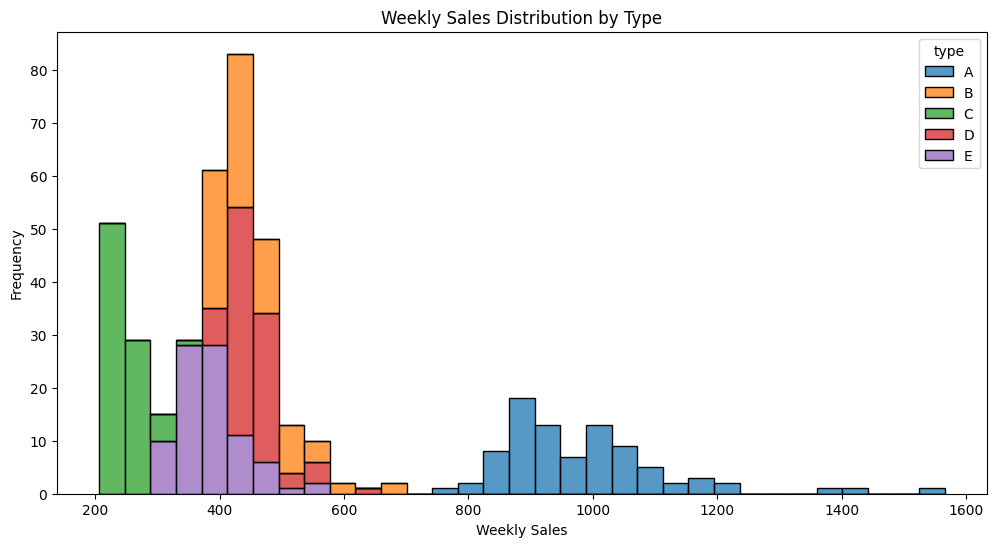

In [24]:
# Assuming you have a date column, aggregate to weekly sales
train_filtered['week'] = train_filtered['date'].dt.to_period('W').astype(str)
weekly_sales = train_filtered[train_filtered.date.dt.year > 2015].groupby(['week', 'type'])['sales'].mean().reset_index()

# Plot the aggregated data
plt.figure(figsize=(12, 6))
sns.histplot(data=weekly_sales, x='sales', hue='type', multiple='stack', kde=False)
plt.title('Weekly Sales Distribution by Type')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')
plt.show()


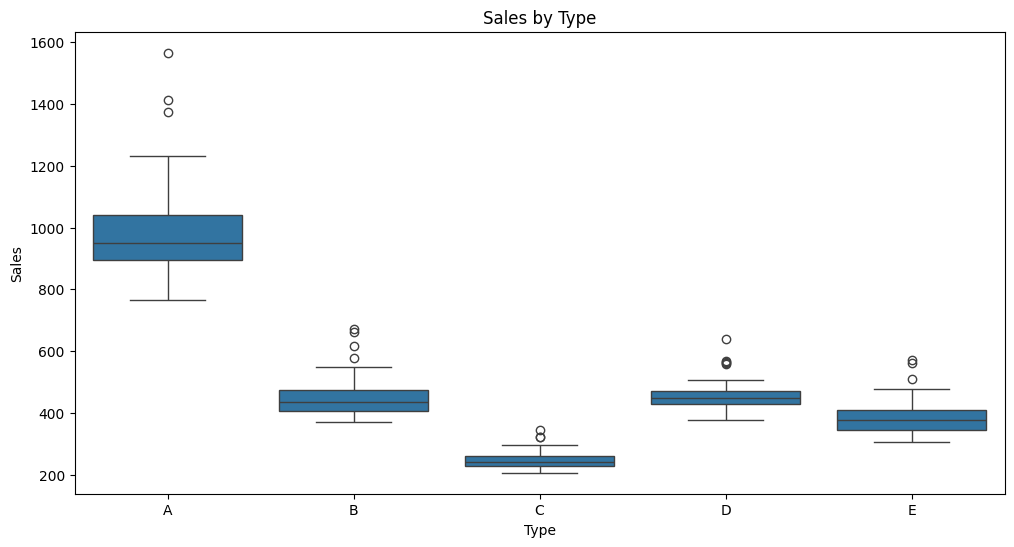

In [25]:
# Boxplot of sales by type (usually faster than histograms with KDE)
plt.figure(figsize=(12, 6))
sns.boxplot(x='type', y='sales', data=weekly_sales)
plt.title('Sales by Type')
plt.xlabel('Type')
plt.ylabel('Sales')
plt.show()

In [26]:
train_filtered['city_new'] = np.where(train_filtered['city'] == 'Quito', 'Quito', 'Other')
merged_test_with_lags['city_new'] = np.where(merged_test_with_lags['city'] == 'Quito', 'Quito', 'Other')
merged_test_with_lags.head()

,id,date,store_nbr,family,onpromotion,city,state,type,cluster,holiday_type,locale,holiday_description,transferred,sales_lag_30,sales_lag_60,sales_lag_180,sales_lag_365,city_new
3008016,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,NA,NA,NA,NA,2.00,3.00,7.00,4.00,Quito
3009798,3002670,2017-08-17,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,NA,NA,NA,NA,3.00,2.00,3.00,5.00,Quito
3011580,3004452,2017-08-18,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,NA,NA,NA,NA,7.00,3.00,0.00,4.00,Quito
3013362,3006234,2017-08-19,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,NA,NA,NA,NA,4.00,3.00,2.00,6.00,Quito
3015144,3008016,2017-08-20,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,NA,NA,NA,NA,10.00,1.00,2.00,12.00,Quito


In [27]:
def one_hot_encoding(train,test,cat_features):
    ohe = OneHotEncoder()
    
    ohe_train = ohe.fit_transform(train[cat_features]).toarray()
    ohe_train = pd.DataFrame(ohe_train,columns=ohe.get_feature_names_out())
    train.drop(cat_features,axis=1,inplace=True)
    train.reset_index(drop=True,inplace=True)
    train = pd.concat([train,ohe_train],axis=1)
    
    ohe_test = ohe.transform(test[cat_features]).toarray()
    ohe_test = pd.DataFrame(ohe_test,columns=ohe.get_feature_names_out())
    test.drop(cat_features,axis=1,inplace=True)
    test.reset_index(drop=True,inplace=True)
    test = pd.concat([test,ohe_test],axis=1)
    
    return (train,test)

In [28]:
train_filtered = train_filtered.drop(columns=['holiday_description','state','city','holiday_type','week'])
merged_test_with_lags = merged_test_with_lags.drop(columns=['holiday_description','state','city','holiday_type'])
cat_features = train_filtered.columns[train_filtered.dtypes=='object']

In [29]:
train_filtered[cat_features] = train_filtered[cat_features].astype(str)
merged_test_with_lags[cat_features] = merged_test_with_lags[cat_features].astype(str)

In [30]:
train_filtered = create_date_features(train_filtered)
merged_test_with_lags = create_date_features(merged_test_with_lags)

In [31]:
dow_avg = train_filtered[train_filtered.date.dt.year >= 2016].groupby(['dow','store_nbr','family'])['sales'].mean().reset_index()
dow_avg = dow_avg.rename(columns={'sales': 'dow_avg'})

dow_type_avg = train_filtered[train_filtered.date.dt.year >= 2016].groupby(['dow','type','family'])['sales'].mean().reset_index()
dow_type_avg = dow_type_avg.rename(columns={'sales': 'dow_type_avg'})

train_filtered = pd.merge(train_filtered, dow_avg, on=['dow', 'store_nbr', 'family'])
merged_test_with_lags = pd.merge(merged_test_with_lags, dow_avg, on=['dow', 'store_nbr', 'family'])

train_filtered = pd.merge(train_filtered, dow_type_avg, on=['dow', 'type', 'family'])
merged_test_with_lags = pd.merge(merged_test_with_lags, dow_type_avg, on=['dow', 'type', 'family'])

In [32]:
train_data,test_data = one_hot_encoding(train_filtered,merged_test_with_lags,cat_features)

In [33]:
#merged_test_with_lags.head()
data_type_A = train_data[(train_data.date.dt.year > 2015) & (train_data.type_A == 1)].copy()
data_type_C = train_data[(train_data.date.dt.year > 2015) & (train_data.type_C == 1)].copy()
data_type_E = train_data[(train_data.date.dt.year > 2015) & (train_data.type_E == 1)].copy()
data_type_BD = train_data[(train_data.date.dt.year > 2015) & ((train_data.type_B == 1) | (train_data.type_D == 1))].copy()

test_data_type_A = test_data[(test_data.type_A == 1)].copy()
test_data_type_C = test_data[(test_data.type_C == 1)].copy()
test_data_type_E = test_data[(test_data.type_E == 1)].copy()
test_data_type_BD = test_data[(test_data.type_B == 1) | (test_data.type_D == 1)].copy()

In [34]:
data_type_A.shape

(160446, 80)

In [94]:
def custom_metric(y,y_pred):
    y_true = np.array(y)
    y_pred = np.array(y_pred)
    y_pred = np.maximum(y_pred, 0)
    log_diff = np.log(1 + y_pred) - np.log(1 + y_true)
    squared_diff = np.square(log_diff)
    mean_squared_diff = np.mean(squared_diff)
    
    return -np.sqrt(mean_squared_diff)

In [38]:
data_type_A.columns[data_type_A.isna().any()]

Index([], dtype='object')

In [ ]:
#train_data.fillna(0, inplace=True)

In [39]:
def prepare_data(train_data, date_col='date', id_col='id', target_col='sales'):
    # Ensure data is sorted by id
    filtered_data = train_data.sort_values(by=[id_col])
    
    # Drop the date and id columns
    filtered_data = filtered_data.drop(columns=[date_col, id_col])
    
    # Define features and target
    X = filtered_data.drop(columns=[target_col])
    y = filtered_data[target_col]
    
    # Train-test split based on temporal order
    split_index = int(len(filtered_data) * 0.8)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    
    return X_train, X_test, y_train, y_test

train_dfs = {
    'A': data_type_A,
    'BD': data_type_BD,
    'C': data_type_C,
    'E': data_type_E
}

# Create dictionaries to store the outputs
X_train_dict = {}
X_test_dict = {}
y_train_dict = {}
y_test_dict = {}

# Prepare data for each train DataFrame and store in the dictionaries
for df_name, train_df in train_dfs.items():
    X_train, X_test, y_train, y_test = prepare_data(train_df)

    print(f"Prepared data for {df_name}:")
    print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}\n")
    # Store the results in the dictionaries with appropriate names
    X_train_dict[f'{df_name}'] = X_train
    X_test_dict[f'{df_name}'] = X_test
    y_train_dict[f'{df_name}'] = y_train
    y_test_dict[f'{df_name}'] = y_test


Prepared data for A:
X_train shape: (128356, 77), X_test shape: (32090, 77)
y_train shape: (128356,), y_test shape: (32090,)

Prepared data for BD:
X_train shape: (402441, 77), X_test shape: (100611, 77)
y_train shape: (402441,), y_test shape: (100611,)

Prepared data for C:
X_train shape: (234775, 77), X_test shape: (58694, 77)
y_train shape: (234775,), y_test shape: (58694,)

Prepared data for E:
X_train shape: (62515, 77), X_test shape: (15629, 77)
y_train shape: (62515,), y_test shape: (15629,)



In [40]:
X_train_dict.keys()

dict_keys(['A', 'BD', 'C', 'E'])

In [113]:
custom_scorer = make_scorer(custom_metric, greater_is_better=True)

# Random Forest model
rf_model = RandomForestRegressor(n_estimators=200, random_state=28, n_jobs=-1)

# Define the parameter grid
param_grid = {
    'max_depth': [7,9]
}

# Create dictionaries to store the results for each dataset
best_scores = {}
best_params = {}
grid_search_models = {}

# Loop through each dataset
for df_name in X_train_dict.keys():
    print(f"Running model for {df_name}...")
    
    # Access the corresponding X_train and y_train
    X_train = X_train_dict[df_name]
    y_train = y_train_dict[df_name]
    
    # Set up GridSearchCV
    grid_search = GridSearchCV(estimator=rf_model,
                               param_grid=param_grid,
                               scoring=custom_scorer,
                               cv=TimeSeriesSplit(n_splits=4),
                               n_jobs=-1,
                               verbose=1)
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Store the best score, parameters, and the grid search model
    best_scores[df_name] = grid_search.best_score_
    best_params[df_name] = grid_search.best_estimator_.get_params()
    grid_search_models[df_name] = grid_search
    
    # Print the best results
    print(f"Best score for {df_name}: {best_scores[df_name]:.3f}")
    print(f"Best parameters for {df_name}: {best_params[df_name]}")


Running model for A...
Fitting 4 folds for each of 2 candidates, totalling 8 fits
Best score for A: -0.483
Best parameters for A: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 9, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': False, 'random_state': 28, 'verbose': 0, 'warm_start': False}
Running model for BD...
Fitting 4 folds for each of 2 candidates, totalling 8 fits
Best score for BD: -0.476
Best parameters for BD: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 9, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': False, 'rando

In [117]:
pd.DataFrame(grid_search_models['E'].cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,29.75,10.94,2.03,1.47,7,{'max_depth': 7},-0.62,-0.60,-0.61,-0.59,-0.61,0.01,2
1,27.00,10.89,1.51,1.34,9,{'max_depth': 9},-0.60,-0.54,-0.54,-0.54,-0.56,0.02,1


In [118]:
best_scores

{'A': -0.482812975412218,
 'BD': -0.4757728600014981,
 'C': -0.49357038226414107,
 'E': -0.5564545515135291}

In [119]:
# Create a dictionary to store the predictions
predictions_dict = {}

# Loop through each dataset to make predictions using the best parameters
for df_name in X_train_dict.keys():
    print(f"Making predictions for {df_name}...")
    
    # Access the corresponding train and test sets
    X_train = X_train_dict[df_name]
    y_train = y_train_dict[df_name]
    X_test = X_test_dict[df_name]
    y_test = y_test_dict[df_name]
    
    # Get the best parameters for the current dataset
    best_params = grid_search_models[df_name].best_params_
    
    # Refit the model using the best parameters
    best_model = RandomForestRegressor(**best_params)
    best_model.fit(X_train, y_train)
    
    # Make predictions on the test set
    predictions = best_model.predict(X_test_dict[df_name])
    
    # Store the predictions
    predictions_dict[df_name] = predictions

    # Getting custom score 
    print(f"Score for {df_name}: {custom_metric(y_test_dict[df_name],predictions)}")


Making predictions for A...
Score for A: -0.4198232763107745
Making predictions for BD...
Score for BD: -0.42577330932382407
Making predictions for C...
Score for C: -0.4686267434253802
Making predictions for E...
Score for E: -0.497577920605361


Plotting feature importances for A...


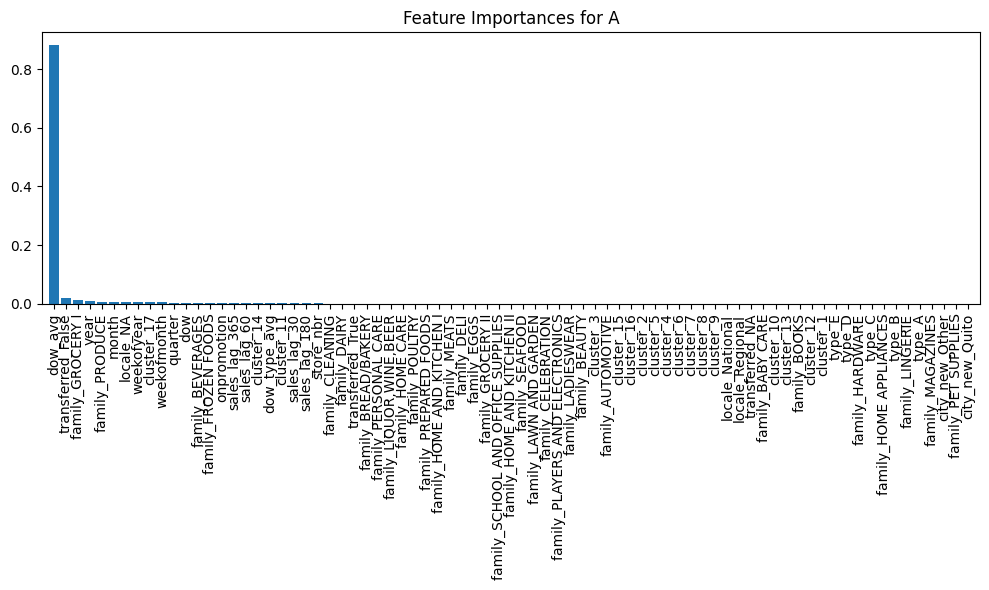

Plotting feature importances for BD...


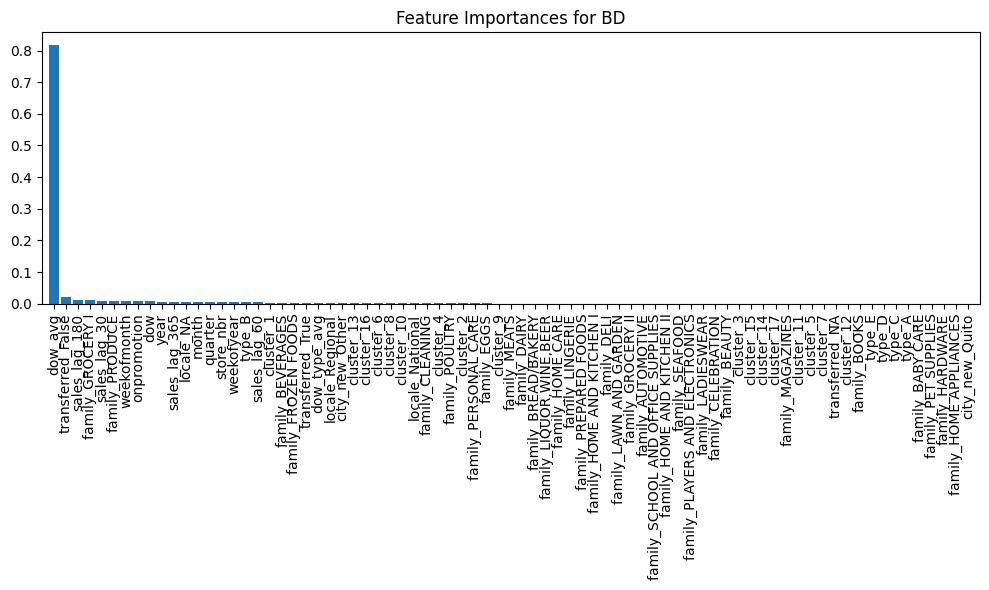

Plotting feature importances for C...


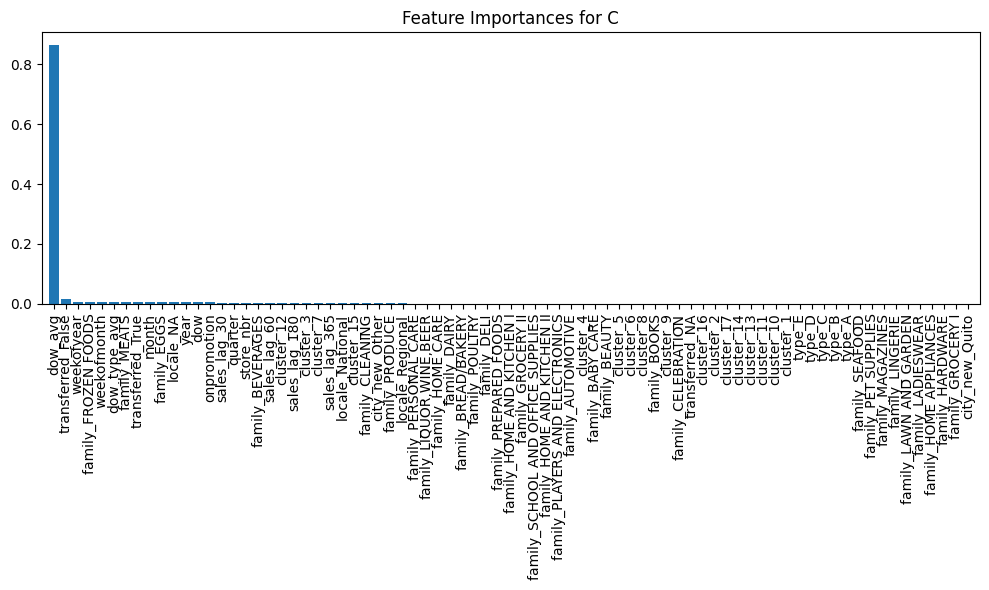

Plotting feature importances for E...


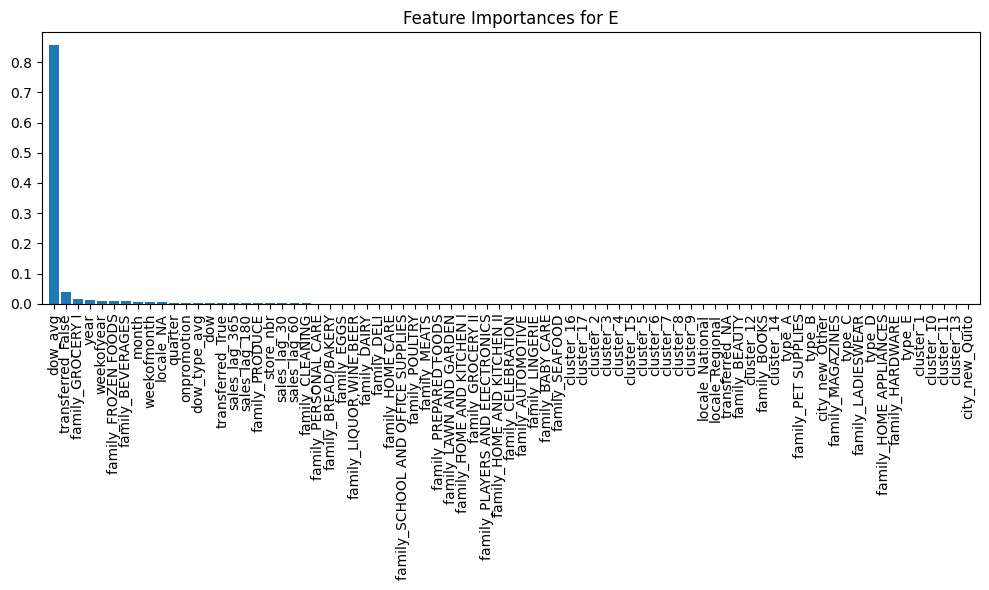

In [103]:
# Loop through each dataset to plot feature importances
for df_name in X_train_dict.keys():
    print(f"Plotting feature importances for {df_name}...")
    
    # Access the corresponding train set (we use this to get the feature names)
    X_train = X_train_dict[df_name]
    
    # Get the best estimator (fitted model) from the grid search
    best_model = grid_search_models[df_name].best_estimator_
    
    # Get the feature importances from the best model
    importances = best_model.feature_importances_
    
    # Get the indices of the features sorted by importance
    indices = np.argsort(importances)[::-1]
    
    # Get the names of the features sorted by importance
    feature_names = X_train.columns
    
    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importances for {df_name}")
    plt.bar(range(X_train.shape[1]), importances[indices], align="center")
    plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
    plt.xlim([-1, X_train.shape[1]])
    plt.tight_layout()
    plt.show()


In [120]:
ta_copy = test_data_type_A.copy()
tbd_copy = test_data_type_BD.copy()
tc_copy = test_data_type_C.copy()
te_copy = test_data_type_E.copy()

In [121]:
# Create a dictionary to store the test predictions
test_predictions_dict = {}

test_data_dict = {
    'A': test_data_type_A,
    'BD': test_data_type_BD,
    'C': test_data_type_C,
    'E': test_data_type_E
}

# Loop through each dataset to make predictions on the test data
for df_name in test_data_dict.keys():
    print(f"Making test predictions for {df_name}...")
    
    # Access the corresponding test set
    X_test = test_data_dict[df_name].drop(columns=['date','id'])
    
    # Get the best estimator (fitted model) from the grid search
    best_model = grid_search_models[df_name].best_estimator_
    
    # Make predictions on the test set
    test_preds = best_model.predict(X_test)
    
    # Apply post-processing to set negative predictions to zero
    test_preds = np.maximum(test_preds, 0)
    
    # Store the predictions in the dictionary
    test_predictions_dict[df_name] = test_preds

Making test predictions for A...
Making test predictions for BD...
Making test predictions for C...
Making test predictions for E...


In [122]:
predictions_with_id_dict = {}

test_data_dict_copy = {
    'A': ta_copy,
    'BD': tbd_copy,
    'C': tc_copy,
    'E': te_copy
}

for df_name in test_predictions_dict.keys():
    print(f"Joining 'id' column for {df_name}...")
    
    # Get the predictions and corresponding test data
    test_preds = test_predictions_dict[df_name]
    test_data = test_data_dict_copy[df_name]
    
    print(f"Length of preds: {len(test_preds)} Length of test_data: {len(test_data)}")
    # Ensure that the test data contains the 'id' column
    ids = test_data['id'].reset_index(drop=True)
    
    # Convert predictions to a DataFrame
    preds_df = pd.DataFrame(test_preds, columns=['sales'])
    
    # Concatenate the 'id' column with the predictions
    preds_with_id = pd.concat([ids, preds_df], axis=1)
    
    # Store the result in the dictionary
    predictions_with_id_dict[df_name] = preds_with_id
    
    # Print a summary of the merged DataFrame
    print(f"Predictions with 'id' for {df_name}:")
    print(predictions_with_id_dict[df_name].head())


Joining 'id' column for A...
Length of preds: 4752 Length of test_data: 4752
Predictions with 'id' for A:
        id  sales
0  3002142  13.61
1  3003924  12.79
2  3005706  13.65
3  3007488  23.31
4  3009270  21.42
Joining 'id' column for BD...
Length of preds: 13728 Length of test_data: 13728
Predictions with 'id' for BD:
        id  sales
0  3000888   4.04
1  3002670   4.04
2  3004452   4.12
3  3006234   4.12
4  3008016   1.91
Joining 'id' column for C...
Length of preds: 7920 Length of test_data: 7920
Predictions with 'id' for C:
        id  sales
0  3000921   1.94
1  3002703   1.92
2  3004485   2.80
3  3006267   3.30
4  3008049   4.40
Joining 'id' column for E...
Length of preds: 2112 Length of test_data: 2112
Predictions with 'id' for E:
        id  sales
0  3001548   6.20
1  3003330   6.93
2  3005112   6.93
3  3006894   8.81
4  3008676   9.06


In [123]:
combined_predictions_df = pd.concat(predictions_with_id_dict.values(), ignore_index=True)
sorted_predictions_df = combined_predictions_df.sort_values(by='id').reset_index(drop=True)

sorted_predictions_df.head()

,id,sales
0,3000888,4.04
1,3000889,0.20
2,3000890,4.36
3,3000891,2524.95
4,3000892,0.46


In [124]:
sorted_predictions_df.to_csv('sub_5.2.csv', index=False)

In [127]:
sub_4 = pd.read_csv(os.path.join('C:\\Users\\saleh\\Documents\\kaggle_sales_forecast', "sub_4.csv"))

In [129]:
merged = pd.merge(sorted_predictions_df,sub_4,on='id')

In [131]:
merged['sales'] = (merged['sales_x'] + merged['sales_y'])/2

In [133]:
merged[['id','sales']].to_csv('sub_5.3.csv', index=False)